In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import bz2

for dirname, _, filenames in os.walk('/kaggle/input/amazonreviews'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazonreviews/test.ft.txt.bz2
/kaggle/input/amazonreviews/train.ft.txt.bz2


In [2]:
import torch
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


In [3]:
# Path to the compressed file
train_file_path = '/kaggle/input/amazonreviews/train.ft.txt.bz2'
test_file_path = '/kaggle/input/amazonreviews/test.ft.txt.bz2'

# Initialize an empty list to store reviews
train_reviews = []
test_reviews = []

# Open the bz2 file in text mode and read the first 5 lines
with bz2.open(train_file_path, 'rt', encoding='utf-8') as file:
    for i, line in enumerate(file):
        if i >= 1000: # limit to 1000
            break
        train_reviews.append(line.strip())
        
with bz2.open(test_file_path, 'rt', encoding='utf-8') as file:
    for i, line in enumerate(file):
        if i >= 1000: # limit to 1000 lines for testing purposes
            break
        test_reviews.append(line.strip())
            
# Convert to a DataFrame for easier manipulation
df_train = pd.DataFrame(train_reviews, columns=["Train_Review"])
df_test = pd.DataFrame(test_reviews, columns=["Test_Review"])

# Display first few rows of the DataFrame
df_train.head()
# df_test.head()

,Train_Review
0,__label__2 Stuning even for the non-gamer: Thi...
1,__label__2 The best soundtrack ever to anythin...
2,__label__2 Amazing!: This soundtrack is my fav...
3,__label__2 Excellent Soundtrack: I truly like ...
4,"__label__2 Remember, Pull Your Jaw Off The Flo..."


In [4]:
# Extract labels if they exist
df_train['Label'] = df_train['Train_Review'].apply(lambda x: x.split()[0] if x.startswith('__label__') else None)

# Clean review text by removing the label
df_train['Train_Review'] = df_train['Train_Review'].apply(lambda x: ' '.join(x.split()[1:]) if x.startswith('__label__') else x)

# Repeat for df_test
df_test['Label'] = df_test['Test_Review'].apply(lambda x: x.split()[0] if x.startswith('__label__') else None)

df_test['Test_Review'] = df_test['Test_Review'].apply(lambda x: ' '.join(x.split()[1:]) if x.startswith('__label__') else x)

# Show the first few rows with labels
df_train[['Label', 'Train_Review']].head()
# df_test[['Label', 'Test_Review']].head()

,Label,Train_Review
0,__label__2,Stuning even for the non-gamer: This sound tra...
1,__label__2,The best soundtrack ever to anything.: I'm rea...
2,__label__2,Amazing!: This soundtrack is my favorite music...
3,__label__2,Excellent Soundtrack: I truly like this soundt...
4,__label__2,"Remember, Pull Your Jaw Off The Floor After He..."


# EDA start

**Basic statistics analysis**

In [5]:
# Calculate review lengths
df_train['Review_Length'] = df_train['Train_Review'].apply(lambda x: len(x.split()))

# Review length distribution
review_length_stats = df_train['Review_Length'].describe()
print("Review Length Statistics:")
print(review_length_stats)

# Label distribution
label_distribution = df_train['Label'].value_counts()
print("\nLabel Distribution:")
print(label_distribution)

Review Length Statistics:
count    1000.000000
mean       81.718000
std        43.129394
min        16.000000
25%        45.000000
50%        74.000000
75%       111.000000
max       199.000000
Name: Review_Length, dtype: float64

Label Distribution:
Label
__label__1    538
__label__2    462
Name: count, dtype: int64


**To show word frequencies, bigram wordmap etc., tokenize and remove stopwords first**

In [6]:
import string
from transformers import DistilBertTokenizer
from nltk.corpus import stopwords

# Load the pre-trained tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Load English stopwords
stop_words = set(stopwords.words('english'))


# Define a function to remove stopwords and punctuation
def remove_stopwords_and_punctuation(text):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    # Filter out stopwords and punctuation
    filtered_tokens = [
        token for token in tokens
        if token.lower() not in stop_words and token not in string.punctuation
    ]
    return filtered_tokens

# Apply stopword removal to your dataset
df_train['Train_Review'] = df_train['Train_Review'].apply(remove_stopwords_and_punctuation)
df_test['Test_Review'] = df_test['Test_Review'].apply(remove_stopwords_and_punctuation)


# Tokenize the filtered data
encoded_inputs_train = tokenizer(
    df_train['Train_Review'].apply(lambda x: " ".join(x)).tolist(),
    truncation=True, 
    padding=True, 
    max_length=200
)

encoded_inputs_test = tokenizer(
    df_test['Test_Review'].apply(lambda x: " ".join(x)).tolist(),
    truncation=True, 
    padding=True, 
    max_length=200
)

# Show the tokenized output
print(encoded_inputs_train.keys())  # 'input_ids', 'attention_mask'
print(encoded_inputs_train['input_ids'][0])  # Example of tokenized output for a review

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

dict_keys(['input_ids', 'attention_mask'])
[101, 24646, 1001, 1001, 9152, 3070, 2130, 2512, 27911, 2614, 2650, 3376, 23262, 12411, 1001, 1001, 9413, 2100, 2568, 2092, 2052, 28667, 1001, 1001, 18168, 2063, 1001, 1001, 1050, 2094, 2130, 2111, 5223, 6819, 1001, 1001, 1040, 2208, 2189, 2209, 2208, 10381, 1001, 1001, 6902, 1001, 1001, 1051, 2892, 2399, 2412, 2209, 2190, 2189, 10457, 2185, 13587, 9019, 1001, 1001, 13749, 3138, 4840, 1001, 1001, 9413, 3357, 24665, 1001, 1001, 8823, 7334, 3969, 1001, 1001, 11865, 2140, 19505, 2052, 17894, 3087, 14977, 4952, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [7]:
from collections import Counter

# Flatten the list of tokenized input_ids and count the occurrences
all_tokens_train = [token for input_ids in encoded_inputs_train['input_ids'] for token in input_ids]
token_counts_train = Counter(all_tokens_train)

# Get the top 20 most frequent tokens
most_common_tokens_train = token_counts_train.most_common(20)

# Print the tokens and their frequencies
print("Most common tokens and their frequencies:")
for token_id, count in most_common_tokens_train:
    token = tokenizer.decode([token_id])  # Convert token IDs back to text
    print(f"Token: '{token}' - Count: {count}")


Most common tokens and their frequencies:


2024-08-21 22:53:19.421673: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 22:53:19.421805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 22:53:19.547594: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Token: '[PAD]' - Count: 140072
Token: '#' - Count: 10094
Token: '[CLS]' - Count: 1000
Token: '[SEP]' - Count: 1000
Token: 'book' - Count: 872
Token: 'one' - Count: 414
Token: 'read' - Count: 401
Token: 'like' - Count: 328
Token: 's' - Count: 299
Token: 'great' - Count: 276
Token: 'would' - Count: 261
Token: 'good' - Count: 243
Token: 'time' - Count: 223
Token: 'get' - Count: 191
Token: 'movie' - Count: 190
Token: 'well' - Count: 186
Token: 'love' - Count: 182
Token: 'really' - Count: 180
Token: '##e' - Count: 170
Token: 'even' - Count: 162


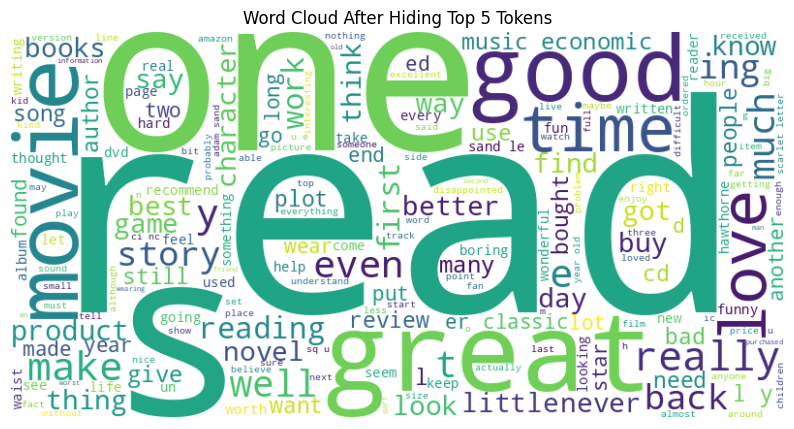

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define K (number of top tokens to hide)
K = 5

# Convert token IDs to text
token_texts_train = [tokenizer.decode([token_id]) for token_id in all_tokens_train]

# Count token frequencies
token_counts_train = Counter(token_texts_train)

# Get the top K most frequent tokens
top_k_tokens_train = [token for token, _ in token_counts_train.most_common(K)]

# Filter out the top K tokens
filtered_token_texts_train = [token for token in token_texts_train if token not in top_k_tokens_train]

# Join the filtered tokens into a single string
filtered_token_texts_str_train = ' '.join(filtered_token_texts_train)

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_token_texts_str_train)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Word Cloud After Hiding Top {K} Tokens')
plt.show()

# EDA end, SA model training start

In [10]:
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Assuming df['Label'] contains the sentiment labels (__label__1 for negative, __label__2 for positive)
# Map the labels from '__label__1' and '__label__2' to 0 and 1
label_mapping = {'__label__1': 0, '__label__2': 1}

# Assuming df['Label'] contains the original labels
df_train['Numeric_Label'] = df_train['Label'].map(label_mapping)

# Convert test labels to numeric format
df_test['Numeric_Label'] = df_test['Label'].map(label_mapping)

# Verify the mapping
print(df_train[['Label', 'Numeric_Label']].head())
print(df_train[['Label', 'Numeric_Label']].tail())

        Label  Numeric_Label
0  __label__2              1
1  __label__2              1
2  __label__2              1
3  __label__2              1
4  __label__2              1
          Label  Numeric_Label
995  __label__1              0
996  __label__1              0
997  __label__2              1
998  __label__1              0
999  __label__1              0


In [15]:
from sklearn.model_selection import train_test_split

# Continue with tokenization and dataset creation...
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Prepare the dataset with the numeric labels
train_dataset = ReviewDataset(encoded_inputs_train, df_train['Numeric_Label'].tolist())
# Prepare the test dataset
test_dataset = ReviewDataset(encoded_inputs_test, df_test['Numeric_Label'].tolist())

# Split the train data into training and evaluation sets
train_dataset, eval_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)

# Load the pre-trained DistilBERT model for sequence classification with 2 labels
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    logging_dir='./logs',            
    logging_steps=10,
    evaluation_strategy="epoch"      
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
# Train the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained('./fine_tuned_sa_model')
tokenizer.save_pretrained('./fine_tuned_sa_model')

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,0.666200,0.443543
2,0.388500,0.270873
3,0.264100,0.270233


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


('./fine_tuned_sa_model/tokenizer_config.json',
 './fine_tuned_sa_model/special_tokens_map.json',
 './fine_tuned_sa_model/vocab.txt',
 './fine_tuned_sa_model/added_tokens.json')

**Training end, test the performance using test dataset first**

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


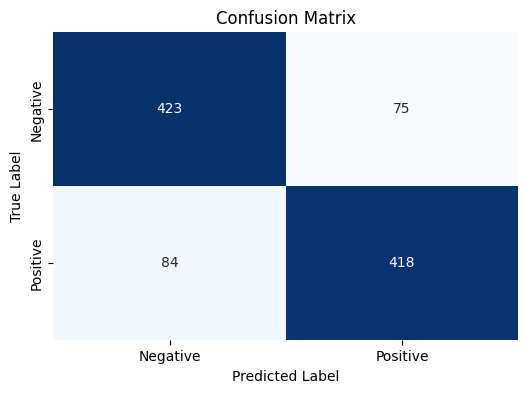

Accuracy: 0.8410
Precision: 0.8479
Recall: 0.8327
F1 Score: 0.8402


In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Generate predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Get the true labels and predicted labels
true_labels = df_test['Numeric_Label'].tolist()
predicted_labels = predictions.predictions.argmax(-1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate Accuracy, Precision, Recall, and F1-score
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

# Print the calculated metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

**Then, test the adaptability on new raw review text**

In [25]:
import torch.nn.functional as F

# Move the model to the appropriate device
model.to(device)

# Input text for prediction
input_text_1 = "I love the book"
input_text_2 = "Literally shit"

# Tokenize the input text and move the tensors to the same device as the model
encoded_input_1 = tokenizer(
    input_text_1, 
    truncation=True, 
    padding=True, 
    max_length=200, 
    return_tensors="pt"  # Return as PyTorch tensors
).to(device)

encoded_input_2 = tokenizer(
    input_text_2, 
    truncation=True, 
    padding=True, 
    max_length=200, 
    return_tensors="pt"  # Return as PyTorch tensors
).to(device)

# Perform the prediction
with torch.no_grad():
    outputs = model(**encoded_input_1)
    logits = outputs.logits

# Apply softmax to convert logits to probabilities
probabilities = F.softmax(logits, dim=1)

# Get the predicted sentiment label (0 for negative, 1 for positive)
predicted_label = torch.argmax(probabilities, dim=1).item()

# Print the results
sentiment_labels = {0: "Negative", 1: "Positive"}
print(f"Predicted Sentiment: {sentiment_labels[predicted_label]}")
print(f"Sentiment Scores (Negative, Positive): {probabilities.tolist()[0]}")

Predicted Sentiment: Positive
Sentiment Scores (Negative, Positive): [0.19866731762886047, 0.8013326525688171]


In [26]:
# Perform the prediction
with torch.no_grad():
    outputs = model(**encoded_input_2)
    logits = outputs.logits

# Apply softmax to convert logits to probabilities
probabilities = F.softmax(logits, dim=1)

# Get the predicted sentiment label (0 for negative, 1 for positive)
predicted_label = torch.argmax(probabilities, dim=1).item()

# Print the results
sentiment_labels = {0: "Negative", 1: "Positive"}
print(f"Predicted Sentiment: {sentiment_labels[predicted_label]}")
print(f"Sentiment Scores (Negative, Positive): {probabilities.tolist()[0]}")

Predicted Sentiment: Negative
Sentiment Scores (Negative, Positive): [0.9072965383529663, 0.09270348399877548]
